# a) Load dataset

In [4]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train, y_train = x_train[:1000]/255, y_train[:1000]
x_test, y_test = x_test[:3000]/255, y_test[:3000]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

4431872/4422102 [==============================] - 5s 1us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(1000, 28, 28) (1000,) (3000, 28, 28) (3000,)


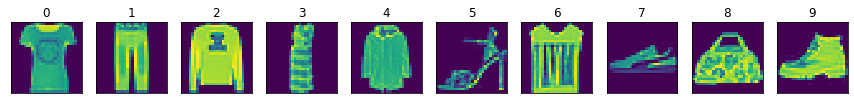

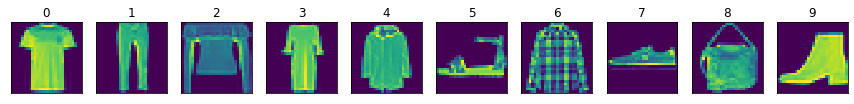

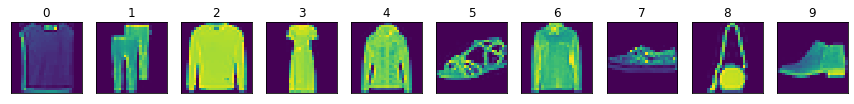

In [6]:
def plot_pics(x: np.ndarray, y: np.ndarray):
    fig = plt.figure(figsize=(15, 4))
    for class_num in range(10):
        class_indices = np.where(y == class_num)[0]
        class_x = x[class_indices]
        rnd_idx = np.random.randint(len(class_x))
        image = class_x[rnd_idx]
        ax = fig.add_subplot(1, 10, class_num + 1, xticks=[], yticks=[])
        ax.set_title(class_num)
        plt.imshow(image)
    plt.show()

for i in range(3):
    plot_pics(x_train, y_train)

# b) Self-Organaizing Map (SOM)

In [20]:
class SOM:
    def __init__(self, input_size=784, output_shape=(15, 15), 
                 radius_of_neighborhood=1, radius_of_neighborhood_reduction=0,
                 learning_rate=0.6, learning_rate_decay=0.99):
        self.input_size = input_size
        self.output_shape = output_shape
        self.output_size = self.output_shape[0] * self.output_shape[1]
        self.weights = np.random.rand(input_size, self.output_size)  # 784 * 15 * 15
        
        self.radius_of_neighborhood = radius_of_neighborhood
        self.radius_of_neighborhood_reduction = radius_of_neighborhood_reduction
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay

    def __find_neighbors(self, output_node):
        neighbors = []
        cols = self.output_shape[0]
        row, col = int(output_node / cols), output_node % cols
        radius = self.radius_of_neighborhood
        for r in range(row - radius, row + radius + 1):
            for c in range(col - radius, col + radius + 1):
                neighbors.append(r * cols + c)
        return neighbors

    def train(self, x_train, epochs=10, plot_weights=True):
        for epoch in tqdm(range(epochs)):
            for x in x_train:
                x = x.flatten()
                distances = np.sum((self.weights.T - x) ** 2, axis=-1)
                min_dist_node = np.argmin(distances)
                neighbor_nodes = self.__find_neighbors(min_dist_node)
                for node in neighbor_nodes:
                    try:
                        self.weights[:, node] += self.learning_rate * (x - self.weights[:, node])
                    except:
                        pass

            self.learning_rate *= self.learning_rate_decay
            self.radius_of_neighborhood = min(self.radius_of_neighborhood, 
                                              self.radius_of_neighborhood - self.radius_of_neighborhood_reduction)
            if plot_weights and epoch in [0, 1, 4, 9]:
                self.plot_weights(epoch + 1)

    def evaluate(self, x_test, y_test):
        nodes_assigned_inputs = np.zeros(self.output_size)
        nodes_assigned_classes = [np.zeros(len(np.unique(y_test))) for i in range(self.output_size)]
        nodes_assigned_classes_set = [set() for i in range(self.output_size)]
        for x, y in zip(x_test, y_test):
            x = x.flatten()
            distances = np.sum((self.weights.T - x) ** 2, axis=-1)
            min_dist_node = np.argmin(distances)
            nodes_assigned_inputs[min_dist_node] += 1
            nodes_assigned_classes[min_dist_node][y] = 1
            nodes_assigned_classes_set[min_dist_node].add(y)
        nodes_assigned_classes_set = np.array([len(n) for n in nodes_assigned_classes_set])
        self.__plot_bar(nodes_assigned_inputs, title="Assigned Inputs", xlabel="Output Neuron", ylabel="Assigned Inputs")
        self.__plot_bar_stacked(nodes_assigned_classes, title="Assigned Classes", xlabel="Output Neuron", ylabel="Assigned Classes")
        print("More than 1 class #neurons:", len(nodes_assigned_classes_set[nodes_assigned_classes_set > 1]))

    def __plot_bar(self, height, title, xlabel, ylabel):
        fig = plt.figure(figsize=(23, 5))
        plt.bar(range(len(height)), height)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def __plot_bar_stacked(self, height, title, xlabel, ylabel):
        df = pd.DataFrame(height)
        df.plot(kind='bar', stacked=True, title=title, 
                figsize=(23, 5), fontsize=5)
        plt.show()

    def plot_weights(self, epoch):
        fig = plt.figure(figsize=(6, 6))
        image = self.weights.reshape(28, 28, -1)
        for i in tqdm(range(self.output_size)):
            plt.subplot(15, 15, i + 1)
            plt.imshow(image[:, :, i])
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        print(f"### EPOCH {epoch} ###")
        plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 1 ###


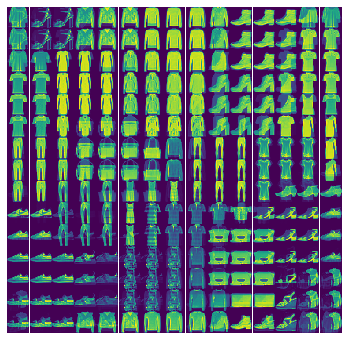

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 2 ###


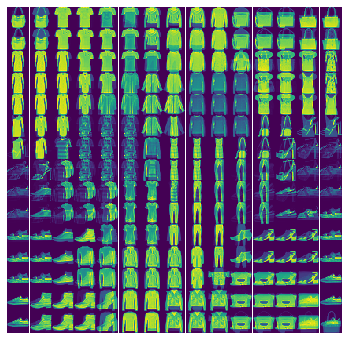

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 5 ###


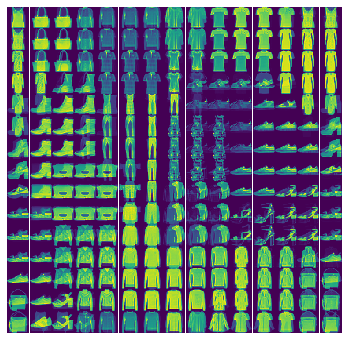

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 10 ###


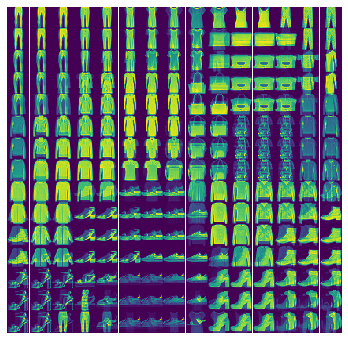

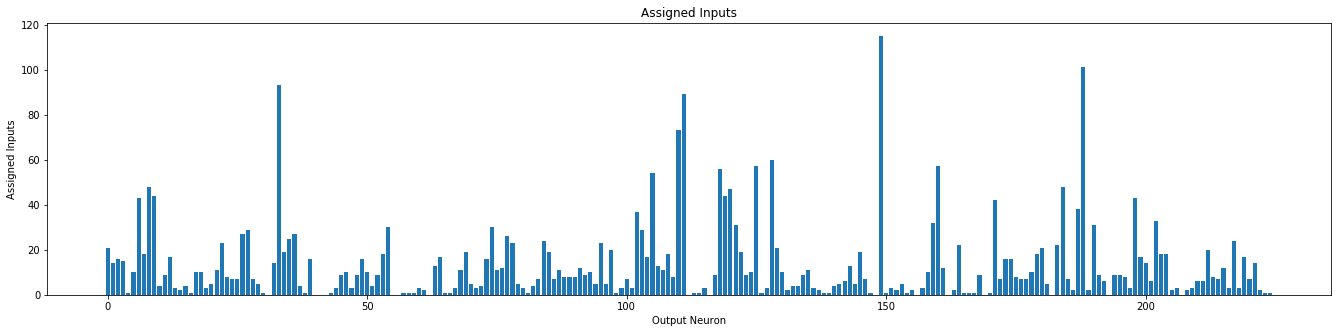

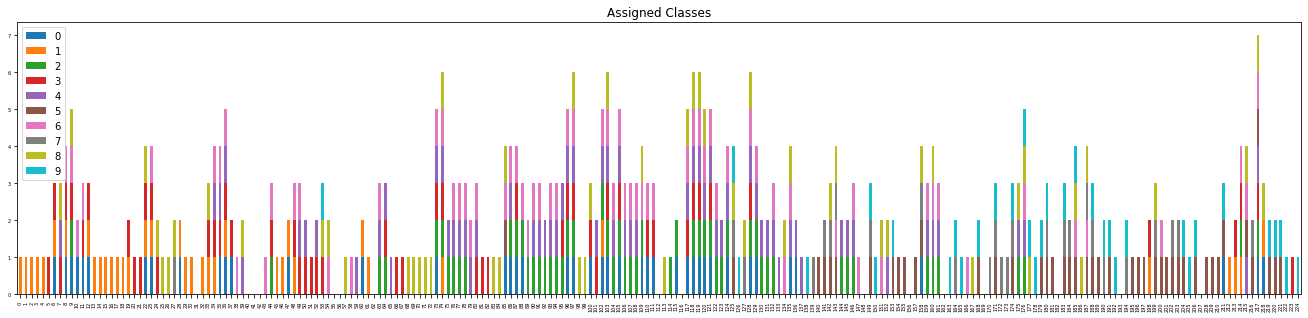

More than 1 class #neurons: 130


In [35]:
som = SOM(input_size=784, output_shape=(15, 15), 
          radius_of_neighborhood=1, radius_of_neighborhood_reduction=0,
          learning_rate=0.7, learning_rate_decay=0.99)
som.train(x_train, epochs=10, plot_weights=True)
som.evaluate(x_test, y_test)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 1 ###


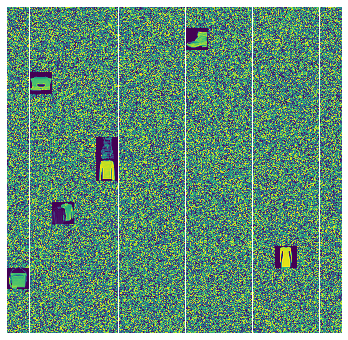

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 2 ###


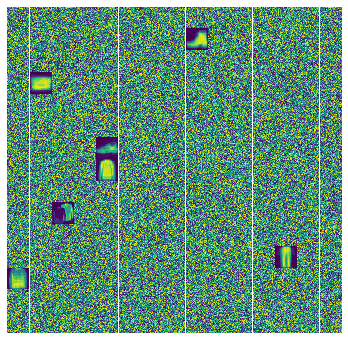

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 5 ###


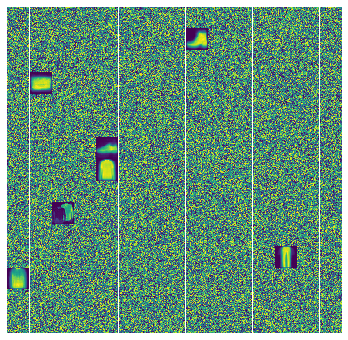

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 10 ###


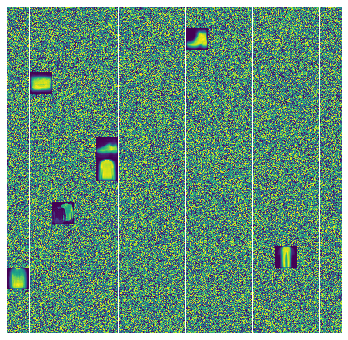

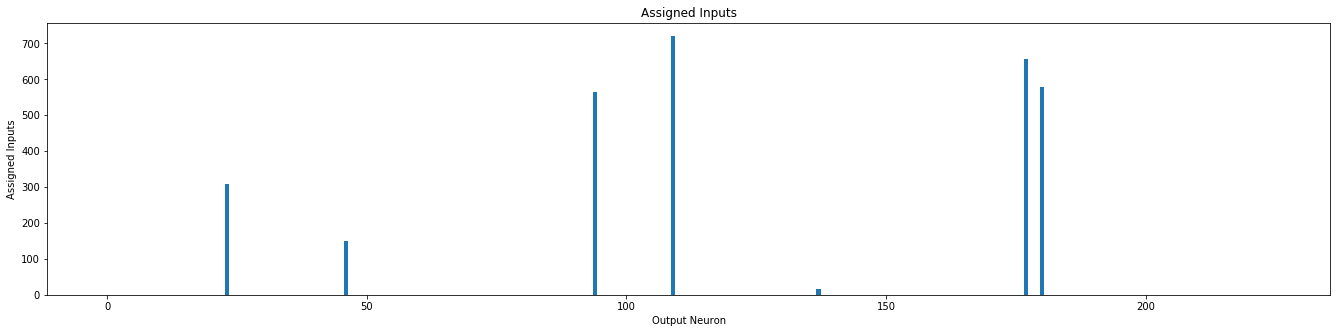

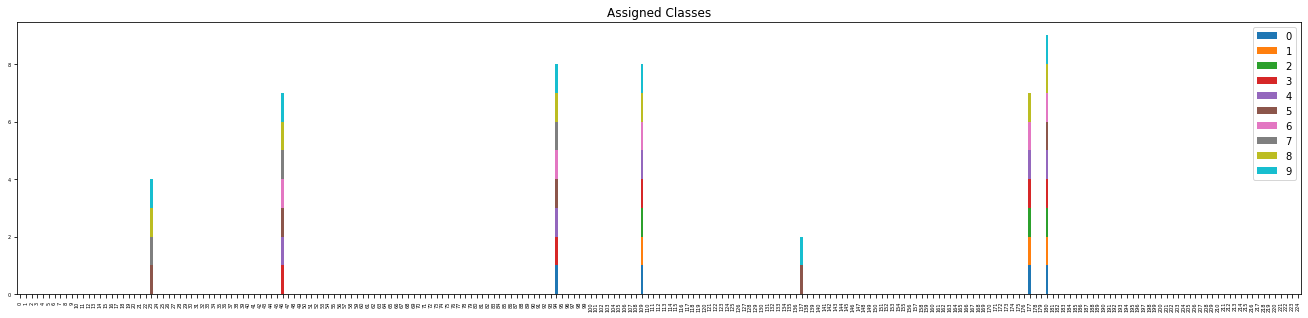

More than 1 class #neurons: 7


In [30]:
# Bonus
som = SOM(radius_of_neighborhood=0,
          learning_rate=1.0, learning_rate_decay=0.1)
som.train(x_train, epochs=10, plot_weights=True)
som.evaluate(x_test, y_test)

# c)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 1 ###


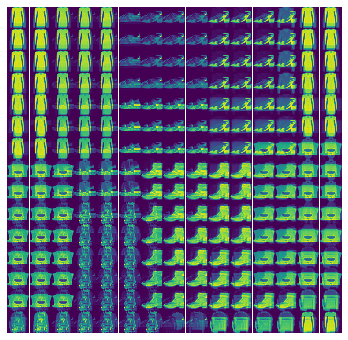

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 2 ###


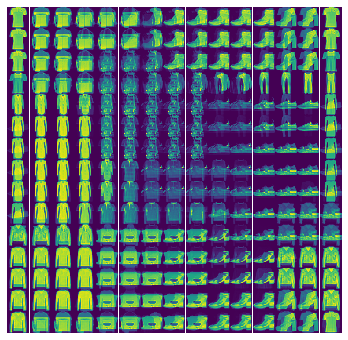

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 5 ###


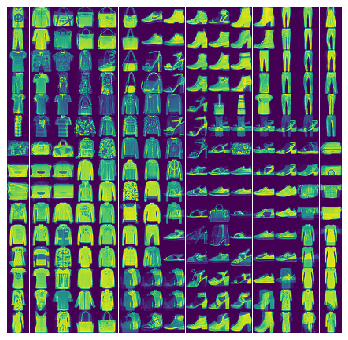

  0%|          | 0/225 [00:00<?, ?it/s]

### EPOCH 10 ###


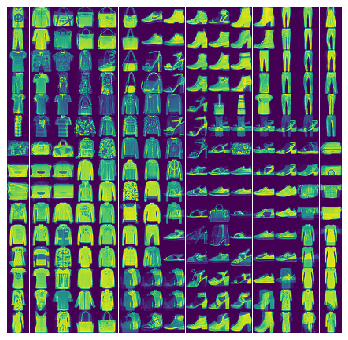

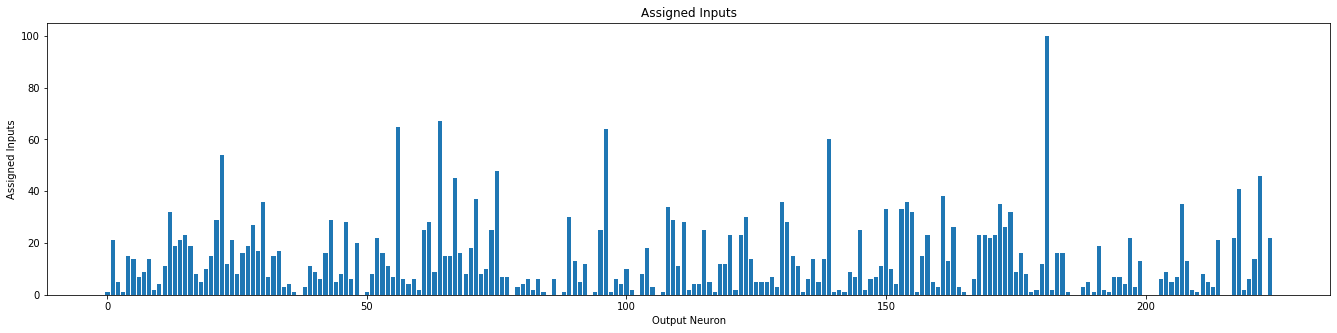

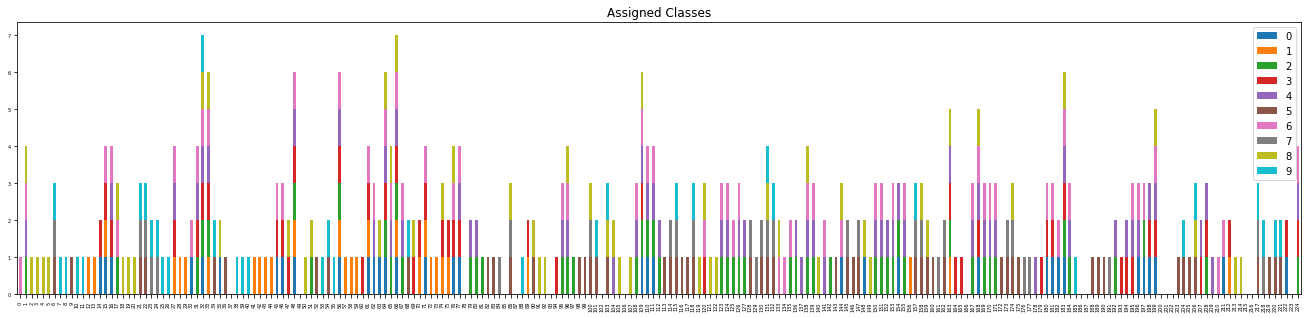

More than 1 class #neurons: 120


In [23]:
som = SOM(radius_of_neighborhood=3, radius_of_neighborhood_reduction=1, 
          learning_rate=0.6, learning_rate_decay=0.99)
som.train(x_train, epochs=10, plot_weights=True)
som.evaluate(x_test, y_test)